In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hongsukyi/Lectures/main/vds/vds.csv')
df.head(2)

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84


In [12]:
df_spd = df.iloc[:,5:6].values
print(df_spd)
print(df_spd.shape)

[[50.3]
 [58.9]
 [50.6]
 ...
 [50.6]
 [59.3]
 [52.5]]
(8064, 1)


In [43]:
max_speed = df_spd.max(); max_speed

87.8

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_df = scaler.fit_transform(df_spd)

scaled_df

array([[0.52350699],
       [0.63278272],
       [0.52731893],
       ...,
       [0.52731893],
       [0.63786531],
       [0.55146125]])

In [14]:
look_back = 144
neuron_1 = 32
neuron_2 = 32

In [15]:
X = []
y = []
for i in range(len(scaled_df)-look_back-1):
    X.append(scaled_df[i:(i+look_back)])
    y.append(scaled_df[(i+look_back)])

X = np.array(X)
y = np.array(y)

In [16]:
print(X.shape, y.shape)

(7919, 144, 1) (7919, 1)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(6335, 144, 1) (6335, 1)
(1584, 144, 1) (1584, 1)


In [18]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential

In [19]:
def simple_rnn():
    model = Sequential([
        SimpleRNN(neuron_1, input_shape=(X_train.shape[1],1)),
        Dense(neuron_2),          
        Dense(1)
    ])    
    
    model.compile(optimizer='adam', loss= 'mse', metrics=['mae'])
    return model

In [20]:
model = simple_rnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


In [21]:
# !pip install livelossplot
from livelossplot import PlotLossesKeras

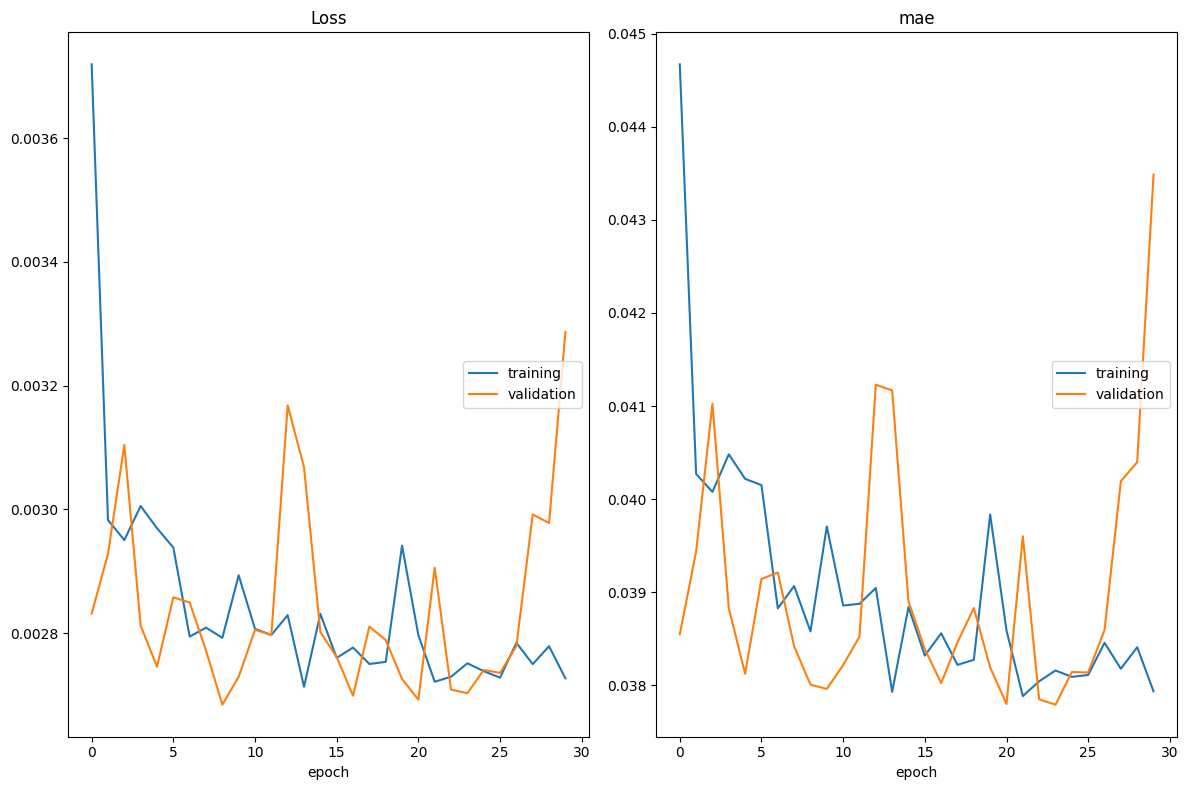

Loss
	training         	 (min:    0.003, max:    0.004, cur:    0.003)
	validation       	 (min:    0.003, max:    0.003, cur:    0.003)
mae
	training         	 (min:    0.038, max:    0.045, cur:    0.038)
	validation       	 (min:    0.038, max:    0.043, cur:    0.043)
179/179 [==============================] - 5s 31ms/step - loss: 0.0027 - mae: 0.0379 - val_loss: 0.0033 - val_mae: 0.0435


In [22]:
history = model.fit(X_train,y_train, epochs=30, 
                    validation_split=0.1,
                    batch_size=32,
                    callbacks=[PlotLossesKeras()])

In [26]:
# 테스트 데이터 세트로 모델 평가: Loss 값 확인 
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print("\nlook_back={:3d},  MSE={:8.4f}, MAE={:8.4f}".format(look_back,mse,mae))


look_back=144,  MSE=  0.0033, MAE=  0.0437


In [34]:
y_pred = model.predict(X_test, verbose=0)
print(y_pred.shape,y_test.shape)

(1584, 1) (1584, 1)


In [35]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [36]:
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

,Actual,Predicted
0,47.4,47.543636
1,46.3,49.043751
2,51.8,48.800835
3,51.1,50.414066
4,48.0,51.722927


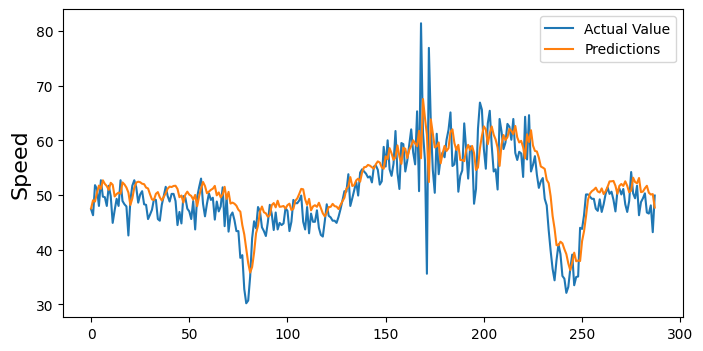

In [37]:
plt.figure(figsize=(8,4))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df[:288])
plt.legend(['Actual Value', 'Predictions'])
plt.show()

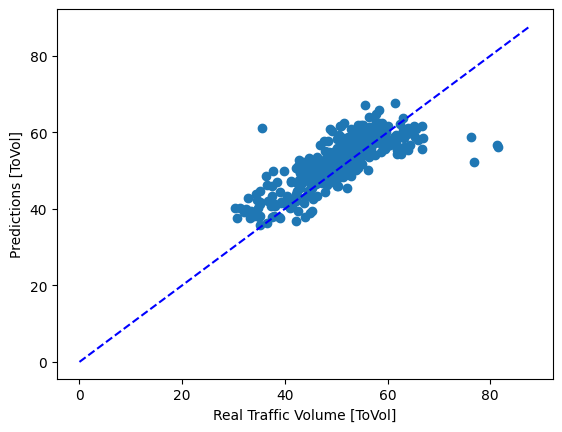

In [44]:
plt.scatter(y_test.flatten()[:576], y_pred.flatten()[:576])
plt.xlabel('Real Traffic Volume [ToVol]')
plt.ylabel('Predictions [ToVol]')
plt.plot([0, max_speed], [0, max_speed],'b--')

In [ ]:
plt.figure(figsize=(10,6))
#plt.style.use("dark_background")

plt.plot(df["Date"].iloc[-576:], df_uni[-576:], linewidth= 3,  color='#d92628', label='Actual Speed')
plt.plot(y_pred[-576:], color='#26D9D7', linewidth= 3, label='Predicted Speed')
plt.xlabel("Date", size="18")
plt.ylabel("Traffic Speed ", size="18")
plt.xticks([0, 48, 96, 144,192, 240, 288, 336, 384, 432, 480, 528,575],rotation=45)

plt.tight_layout()
plt.legend()

In [ ]:
plt.scatter(pred_df)